Epoch 0, Loss: 0.9618428349494934
Epoch 1000, Loss: 0.0022526364773511887
Epoch 2000, Loss: 2.304132613062393e-05
Epoch 3000, Loss: 3.1213319289236097e-06
Converged at epoch 3849, Loss: 9.99549001790001e-07
Eigenvalue:  90.13038


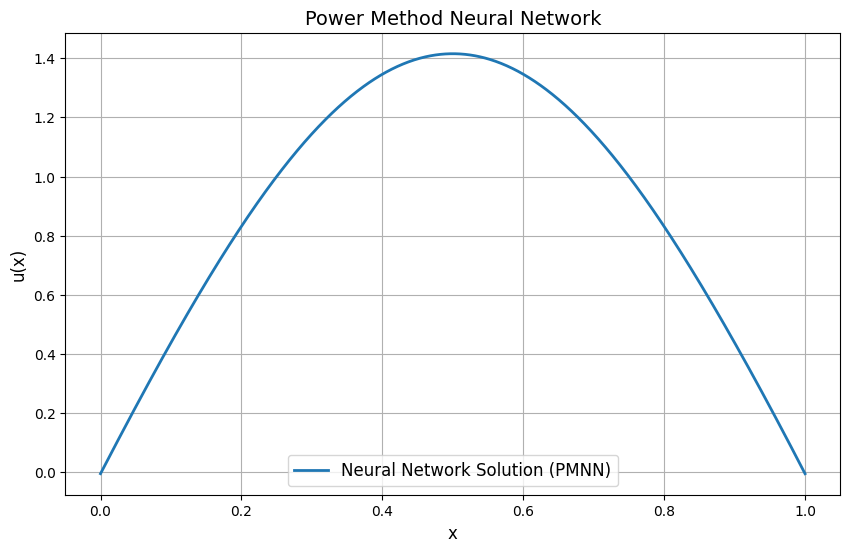

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Neural network definition
class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(DeepNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.network(x)

# Hyperparameters
L = 1  # Length of region
input_dim = 1
hidden_dim = 20
output_dim = 1
num_layers = 5
N = 1000  # Number of points
N_epoch = 40000
lr = 0.001 
epsilon = 1e-6

# Training dataset
x = torch.linspace(0, L, N).view(-1, 1).requires_grad_(True)

# Neural network initialization
net = DeepNet(input_dim, hidden_dim, output_dim, num_layers)
optimizer = optim.Adam(net.parameters(), lr=lr)

# Boundary conditioning function
def phi(x):
    return x * (L - x)

# Laplacian operator
def laplacian(u, x):
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True, retain_graph=True)[0]
    return u_xx + 100.0*u

# PMNN Loss function
def pmnn_loss(U_k_minus_1, U_k):
    return ((U_k_minus_1 - U_k) ** 2).mean()

# Training loop
U_k_minus_1 = phi(x) * net(x)  # Initial guess
for epoch in range(N_epoch):
    # Compute Laplacian of U_k_minus_1
    P_k = laplacian(U_k_minus_1, x)

    # Normalize P_k to obtain U_k
    norm_P_k = torch.sqrt((P_k ** 2).mean())
    U_k = P_k / norm_P_k

    # Compute PMNN loss
    loss = pmnn_loss(U_k_minus_1, U_k)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update U_k_minus_1 for the next iteration
    U_k_minus_1 = phi(x) * net(x)

    # Print progress
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Stopping criterion
    if loss.item() < epsilon:
        print(f"Converged at epoch {epoch}, Loss: {loss.item()}")
        break


# Compare with analytical solution
x_np = x.detach().numpy().flatten()
u_nn = U_k.detach().numpy().flatten()
LU_k_minus_1_nn = P_k.detach().numpy().flatten()
U_k_minus_1_nn = U_k_minus_1.detach().numpy().flatten()
eigenval = np.dot(LU_k_minus_1_nn, U_k_minus_1_nn)/np.dot(U_k_minus_1_nn, U_k_minus_1_nn)
print("Eigenvalue: ", eigenval)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_np, u_nn, label="Neural Network Solution (PMNN)", linewidth=2)
plt.title("Power Method Neural Network", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("u(x)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
